# Using TissUUmaps to visualize CNN features

This notebook will show you how to visualize convolutional neural network (CNN) features using TissUUmaps. After completing it, you will be able to extract morphological features from any spatial transcriptomics (ST) dataset using any pretrained CNN. In the end, we will have a vector of features for every ST spot in the image, that we can then reduce to 3 dimensions and map back to the image as RGB colors.

The steps to achieve this are:
1. Import the necessary libraries
2. Load Visium 10X data using ScanPy
3. Load the CNN model using TensorFlow
4. Extract features and reduce dimensionality
5. Visualize the results in TissUUmaps

## 1. Import the necessary libraries

Apart from the common data handling libraries, the main libraries that will be used in this example are:
* [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html) 
* [OpenSlide Python](https://openslide.org/api/python/)  
* [TensorFlow](https://www.tensorflow.org/)  
* [UMAP](https://umap-learn.readthedocs.io/en/latest/)
* [TissUUmaps](https://github.com/wahlby-lab/FlaskTissUUmaps)
 
So please make sure you have them correctly installed following the provided instructions.

In [1]:
import tissuumaps.jupyter as tmap

import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import scanpy as sc
import openslide
import tensorflow as tf
import umap.umap_ as umap

import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
from skimage import color

## 2. Load Visium 10X data using Scanpy

Use ScanPy to download sample Visium 10X data. The code bellow will create a directory **data** wherever this file is located, containing the *TIFF image* and the *CSV with barcodes* for the corresponding sample. 

For other possible samples, please visit:  [https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.visium_sge.html#scanpy.datasets.visium_sge](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.visium_sge.html#scanpy.datasets.visium_sge)

In [2]:
# Choose the sample_id to load
sample_id = 'V1_Adult_Mouse_Brain'
# The include_hires_tiff=True instruction will download the data locally
adata = sc.datasets.visium_sge(sample_id=sample_id, include_hires_tiff=True)
# Define the image path
image_path = adata.uns["spatial"][sample_id]["metadata"]["source_image_path"]
# The parent directory is our data path
data_path = os.path.dirname(image_path)
# We get the positions path by going into ../spatial/tissue_positions_list.csv from the image folder
pos_path = os.path.join(data_path,"spatial","tissue_positions_list.csv")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Use TissUUmaps now to visualize the raw image and also create a TissUUmaps project which will prepare the sample for loading in Python.

In [3]:
# Create TissUUmaps projects file
tmap.opentmap(image_path, port=5000)

Use OpenSlide to load the image in Python and print image properties.

In [4]:
# The TissUUmaps project file will be located in ../.tissuumaps/image.tif from the image folder
tissuumaps_image_path = os.path.join(data_path,".tissuumaps","image.tif")
# Open the image using OpenSlide
image = openslide.OpenSlide(tissuumaps_image_path)

# Print some image characteristics:
print("Image maximum resolution (x,y): (" + image.properties['tiff.XResolution'] + "X, "  + image.properties['tiff.YResolution'] + "X)")
print("Size at maximum resolution (width, height): (" + image.properties['openslide.level[0].width'] + ", "  + image.properties['openslide.level[0].height'] + ")")

Image maximum resolution (x,y): (10X, 10X)
Size at maximum resolution (width, height): (11291, 11757)


Use pandas to load the positions file and print 5 sample rows.

In [5]:
# Read the positions list and show random samples
pos = pd.read_csv(pos_path, names=["barcode", "in_tissue", "array_y", "array_x", "image_y", "image_x"])
pos.sample(5)

,barcode,in_tissue,array_y,array_x,image_y,image_x
828,CATGCTGGCTCCAATT-1,1,12,60,2688,5339
4420,CCTATGGTCAAAGCTG-1,1,68,68,9392,5889
3953,TACGCTCGGTATTGGA-1,0,61,113,8554,8985
202,AGTTATTGAAAGGTAA-1,0,2,74,1491,6302
171,AAACAATCTACTAGCA-1,1,3,43,1611,4169


## 3. Load the CNN model using TensorFlow

Upload the model we want to use for feature extraction. In this case, an InceptionV3 model pretrained on ImageNet from TensorFlow was used. Note that this model is not used for classification, so the top classification layer is not included. Instead, a last pooling layer is added to aggregate the last convolutional output into a vector. For this example, the model will yield 2048 features for each ST spot.
Remember also to change the **patch_size** depending on the desired amount of spatial context around each ST spot.

To see other possible models, please visit:  [https://www.tensorflow.org/api_docs/python/tf/keras/applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [6]:
# Define patch size depending on the amount of spatial context desired
patch_size = 256

# Load the base model
input_shape = (patch_size, patch_size, 3)
base_model = tf.keras.applications.InceptionV3(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

# Add last pooling layer to aggregate last convolutional output into a vector
inputs = tf.keras.Input(shape=input_shape)
base_output = base_model(inputs)
out = tf.keras.layers.GlobalAveragePooling2D()(base_output)

# Create the feature extractor CNN
model = tf.keras.models.Model(inputs=inputs,outputs=out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


## 4. Extract features and reduce dimensionality

Divide the image into tiles of the previously defined **patch_size** centered around each ST spot and extract features for such tiles. The results are saved in the same folder.

100%|██████████| 2702/2702 [08:34<00:00,  5.25it/s]


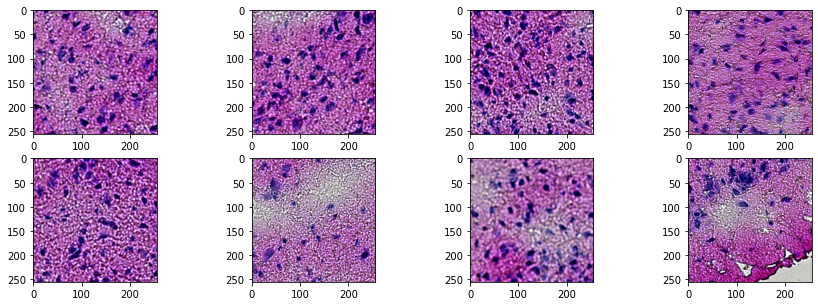

In [7]:
# We are only interested in the spots inside the tissue
pos_tissue = pos[pos.in_tissue==1]
# Define the number of patches
n_patches = len(pos_tissue)
# Create empty vector for features
features = np.empty((n_patches, 2048))

# Plot some random patches for quality control
fig = plt.figure(figsize=(15,5))
random_samples = np.sort(random.sample(range(n_patches), 8))

for i, idx in enumerate(tqdm(pos_tissue.index)): # for every spot in the tissue

    level = 0 # resolution level, where 0 is the maximum resolution
    location = (int(pos_tissue.image_x[idx] - patch_size/2), int(pos_tissue.image_y[idx] - patch_size/2)) # top left corner where we want our region to start
    size = (patch_size, patch_size) # size of the region

    patch = image.read_region(location=location, level=level, size=size) # extract patch
    patch = color.rgba2rgb(patch) #convert to RGB
    patch = np.asarray(patch, dtype='float32') # convert to appropriate format

    if i in random_samples: # plot random samples
        p = int(np.where(random_samples==i)[0])
        plt.subplot(2,4,p+1)
        plt.imshow(patch)

    patch = np.reshape(patch, (1, patch_size, patch_size, 3)) # reshape into appropriate size

    features[i,:] = model(patch) # extract features and store in array


np.save(os.path.join(data_path, "features_"+str(patch_size)),features) # save features into a .npy file
plt.show()


Now each spot has 2048 features associated. In order to visualize them, use UMAP for reducing the dimensionality to 3 components that will be interpreted as the RGB colors.

In [27]:
# Use UMAP to reduce the 2048 features into 3 UMAP components
reducer = umap.UMAP(n_components=3) 
components = reducer.fit_transform(features)
# Convert UMAP components into colorscale
rgb_feat = (components - components.min(axis=0)) / (components.max(axis=0) - components.min(axis=0))
hex_feat = [rgb2hex(rgb_feat[i, :]) for i in range(len(rgb_feat))]
hex_feat = np.reshape(np.array(hex_feat),(len(hex_feat),1))
# Define path for saving .csv
csv_path = os.path.join(data_path,'UMAP.csv')

pd.DataFrame(np.hstack([rgb_feat, pos_tissue[['image_x', 'image_y']], hex_feat]),
        columns=['UMAP1', 'UMAP2', 'UMAP3','x', 'y', 'color']).sort_values(by=['UMAP3']).to_csv(csv_path)

## 5. Visualize the results in TissUUmaps

Finally, use TissUUmaps to map the RGB components extracted from the features to the original spots.

In [28]:
tmap.loaddata(images=image_path, 
              csvFiles=csv_path, 
              xSelector="x", ySelector="y", colorSelector="color", scaleFactor=3, port=5001)

Creating project file C:\Users\educh799\Documents\Research\tissuumaps_example\data\V1_Adult_Mouse_Brain\_project.tmap


Visualize also a pseudo-3D representation of the three UMAP features by scattering UMAP1 - UMAP2 and using UMAP3 for the scale and colormap of the spots.

In [31]:
tmap.loaddata(csvFiles=csv_path, 
              xSelector="UMAP1", ySelector="UMAP2", 
              colorSelector="UMAP3", colormap='interpolateRainbow',
              scaleSelector="UMAP3", scaleFactor=6, port=5002)

Creating project file C:\Users\educh799\Documents\Research\tissuumaps_example\data\V1_Adult_Mouse_Brain\_project.tmap
